In [337]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.signal
import torch
import torch.nn as nn
import torchsummary
import heapq
from sklearn.svm import SVR
import deepdish as dd
from sklearn import preprocessing 

In [338]:
#inisialize
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("cpu")

print(f'Devices: {device}')

Devices: cpu


In [339]:
#read file and load models path
h5path = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/Data/h5/'
pthpath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/Data/pth/'
#read mat file
matpath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/Data/matlib/'
figurepath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/ReproducedCodes/Figures/'
read_temp=scipy.io.loadmat(matpath + 'data2_testall.mat')
S_est=read_temp['S_est']
S_est = S_est.transpose(0, 2, 1)
S_real = np.real(S_est)
S_imag = np.imag(S_est)
S_abs = np.append(S_real, S_imag, axis=2)
S_label=read_temp['S_label']
R_est=read_temp['R_est']
DOA_train=read_temp['DOA_train']
theta=read_temp['theta']
gamma=read_temp['gamma']
gamma_R=read_temp['gamma_R']
S_label1 = np.expand_dims(S_label, 2)
normalizer = preprocessing.Normalizer().fit(R_est)
[r2,I,c] = np.shape(S_est)
[r2,c]=np.shape(R_est)
[r2,I]=np.shape(S_label)
print(f'r2: {r2}, I: {I}, c: {c}')
print(f'S_est: {S_est.shape}, S_abs: {S_abs.shape} \nS_label: {S_label.shape}, \nR_est: {R_est.shape}')

K = 2
DOA = np.arange(I)-60
L = 120

r2: 321, I: 120, c: 56
S_est: (321, 2, 120), S_abs: (321, 2, 240) 
S_label: (321, 120), 
R_est: (321, 56)


In [340]:
class CNN_ReLu(nn.Module):
    def __init__(self):
        super(CNN_ReLu, self).__init__()
        self.cnn_1 = nn.Conv1d(in_channels=2, out_channels=12, kernel_size=25, padding=12)
        self.cnn_2 = nn.Conv1d(in_channels=12, out_channels=6, kernel_size=15, padding=7)
        self.cnn_3 = nn.Conv1d(in_channels=6, out_channels=3, kernel_size=5, padding=2)
        self.cnn_4 = nn.Conv1d(in_channels=3, out_channels=1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.cnn_1(x))
        x = self.relu(self.cnn_2(x))
        x = self.relu(self.cnn_3(x))
        x = self.relu(self.cnn_4(x))
        return x
cnnrelu = torch.load(pthpath + 'cnnrelu.pth')

In [341]:
class CNN_tanh(nn.Module):
    def __init__(self):
        super(CNN_tanh, self).__init__()
        self.cnn_1 = nn.Conv1d(in_channels=2, out_channels=12, kernel_size=25, padding=12)
        self.cnn_2 = nn.Conv1d(in_channels=12, out_channels=6, kernel_size=15, padding=7)
        self.cnn_3 = nn.Conv1d(in_channels=6, out_channels=3, kernel_size=5, padding=2)
        self.cnn_4 = nn.Conv1d(in_channels=3, out_channels=1, kernel_size=3, padding=1)
        self.tanh = nn.Tanh()
    def forward(self, x):
        x = self.tanh(self.cnn_1(x))
        x = self.tanh(self.cnn_2(x))
        x = self.tanh(self.cnn_3(x))
        x = self.tanh(self.cnn_4(x))
        return x
cnntanh = torch.load(pthpath + 'cnntanh.pth')

In [342]:
class CNN_sigmoid(nn.Module):
    def __init__(self):
        super(CNN_sigmoid, self).__init__()
        self.cnn_1 = nn.Conv1d(in_channels=2, out_channels=12, kernel_size=25, padding=12)
        self.cnn_2 = nn.Conv1d(in_channels=12, out_channels=6, kernel_size=15, padding=7)
        self.cnn_3 = nn.Conv1d(in_channels=6, out_channels=3, kernel_size=5, padding=2)
        self.cnn_4 = nn.Conv1d(in_channels=3, out_channels=1, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.sigmoid(self.cnn_1(x))
        x = self.sigmoid(self.cnn_2(x))
        x = self.sigmoid(self.cnn_3(x))
        x = self.sigmoid(self.cnn_4(x))
        return x
cnnsigmoid = torch.load(pthpath + 'cnnsigmoid.pth')

In [343]:
class DNN_ReLU(nn.Module):
    def __init__(self):
        super(DNN_ReLU, self).__init__()
        self.fc1 = nn.Linear(2*L, int(2*L/3))
        self.fc2 = nn.Linear(int(2*L/3), int(4*L/9))
        self.fc3 = nn.Linear(int(4*L/9), int(2*L/3))
        self.fc4 = nn.Linear(int(2*L/3), L)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        return x
dnnrelu = torch.load(pthpath + 'dnnrelu.pth') 

In [344]:
class DNN_Tanh(nn.Module):
    def __init__(self):
        super(DNN_Tanh, self).__init__()
        self.fc1 = nn.Linear(2*L, int(2*L/3))
        self.fc2 = nn.Linear(int(2*L/3), int(4*L/9))
        self.fc3 = nn.Linear(int(4*L/9), int(2*L/3))
        self.fc4 = nn.Linear(int(2*L/3), L)
        self.tanh = nn.Tanh()
    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        return x
dnntanh = torch.load(pthpath + 'dnntanh.pth')

In [345]:
class DNN_Sigmoid(nn.Module):
    def __init__(self):
        super(DNN_Sigmoid, self).__init__()
        self.fc1 = nn.Linear(2*L, int(2*L/3))
        self.fc2 = nn.Linear(int(2*L/3), int(4*L/9))
        self.fc3 = nn.Linear(int(4*L/9), int(2*L/3))
        self.fc4 = nn.Linear(int(2*L/3), L)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x
dnnsigmoid = torch.load(pthpath + 'dnnsigmoid.pth')

In [346]:
def Test(model, inputx):
    model = model.to(device)
    model.eval()
    ls = []
    for i in range(r2):
        with torch.no_grad():
            x = torch.from_numpy(inputx[i,:,:]).float().to(device)
            x = x.to(device)
            y = model(x)
            y = y.cpu().numpy()
            ls.append(y)
    predict = np.array(ls)
    return predict

In [358]:
def DOAPredict(predict, height = 0.1, nodetect = -5):
    peak = np.zeros((K, r2))
    for i in range(predict.shape[0]):
        li = predict[i,0,:].flatten()
        peaks_st = np.zeros((K))
        peaks_st = peaks_st + nodetect
        peaks,_ = scipy.signal.find_peaks(li, height=height)
        maxamp = heapq.nlargest(K, li[peaks])
        
        peakpeak = []
        for k in peaks:
            if k>0 and k<119:
                peakpeak.append(k)
        peaks = np.array(peakpeak)
        
        if len(peaks) == K:
            peaks_st = peaks
        elif len(peaks) == 0:
            peaks_st = peaks_st
        elif len(peaks) < K:
            for t in range(len(peaks)):
                peaks_st[t] = peaks[t]
        elif len(peaks) > K:
            for j in range(K):
                peaks_st[j] = np.where(li==maxamp[j])[0]
        
        peak[:,i] = sorted(peaks_st, reverse=True)
        # if peaks_st[0] > peaks_st[1]:
        #     peak[:,i] = [peaks_st[0], peaks_st[1]]
        # else:
        #     peak[:,i] = [peaks_st[1], peaks_st[0]]
    return peak

In [371]:
predict_cnntanh = Test(cnntanh, S_est)
doa_cnntanh = DOAPredict(predict_cnntanh)
predict_cnnrelu = Test(cnnrelu, S_est)
doa_cnnrelu = DOAPredict(predict_cnnrelu)
predict_cnnsigmoid = Test(cnnsigmoid, S_est)
doa_cnnsigmoid = DOAPredict(predict_cnnsigmoid)

predict_dnntanh = Test(dnntanh, S_abs)
doa_dnntanh = DOAPredict(predict_dnntanh)
predict_dnnrelu = Test(dnnrelu, S_abs)
doa_dnnrelu = DOAPredict(predict_dnnrelu)
predict_dnnsigmoid = Test(dnnsigmoid, S_abs)
doa_dnnsigmoid = DOAPredict(predict_dnnsigmoid)



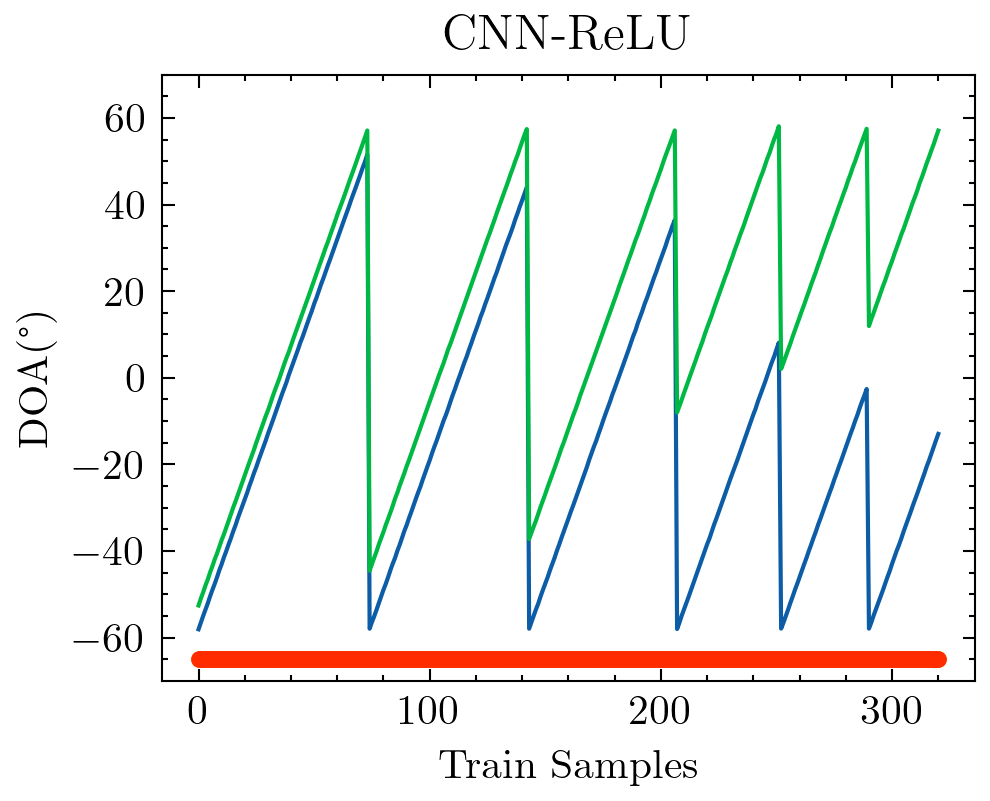

In [366]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(-70,70)
    plt.plot(DOA_train.T)
    plt.plot(doa_cnnrelu.T-60,'.')
    plt.title('CNN-ReLU')
    plt.xlabel('Train Samples')
    plt.ylabel('DOA(°)')
    plt.savefig(figurepath + 'SampleIndex/DCN_ReLU.pdf')
    plt.show()
    

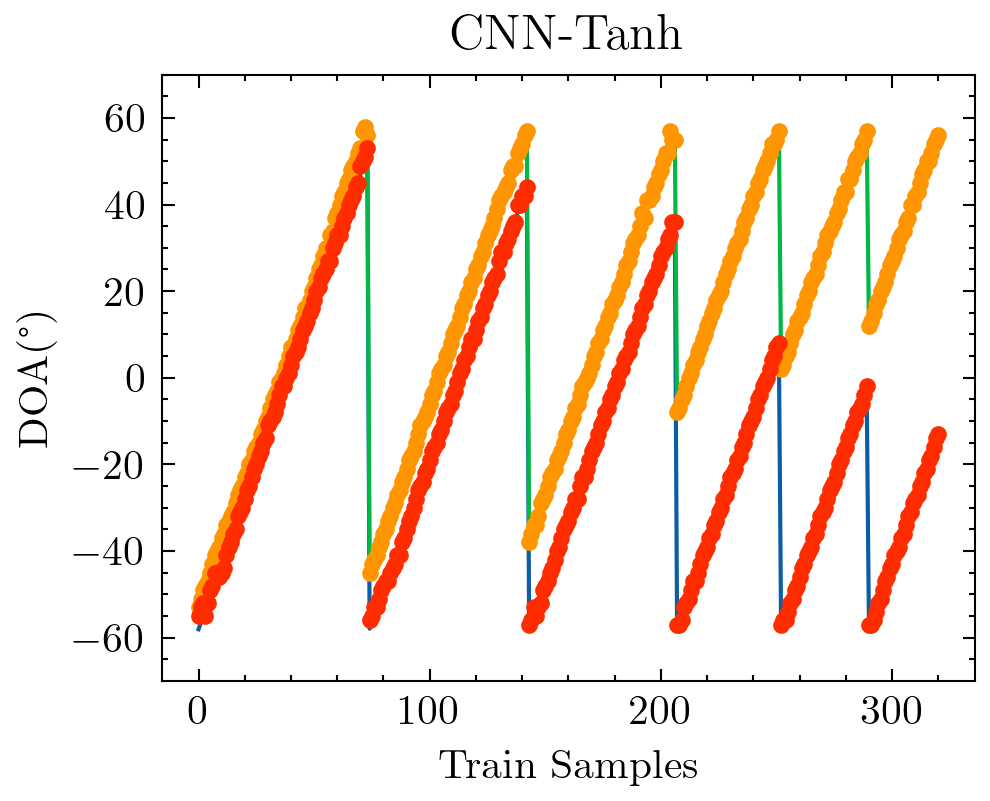

In [367]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(-70,70)
    plt.plot(DOA_train.T)
    plt.plot(doa_cnntanh.T-60,'.')
    plt.title('CNN-Tanh')
    plt.xlabel('Train Samples')
    plt.ylabel('DOA(°)')
    plt.savefig(figurepath + 'SampleIndex/DCN_Tanh.pdf')
    plt.show()

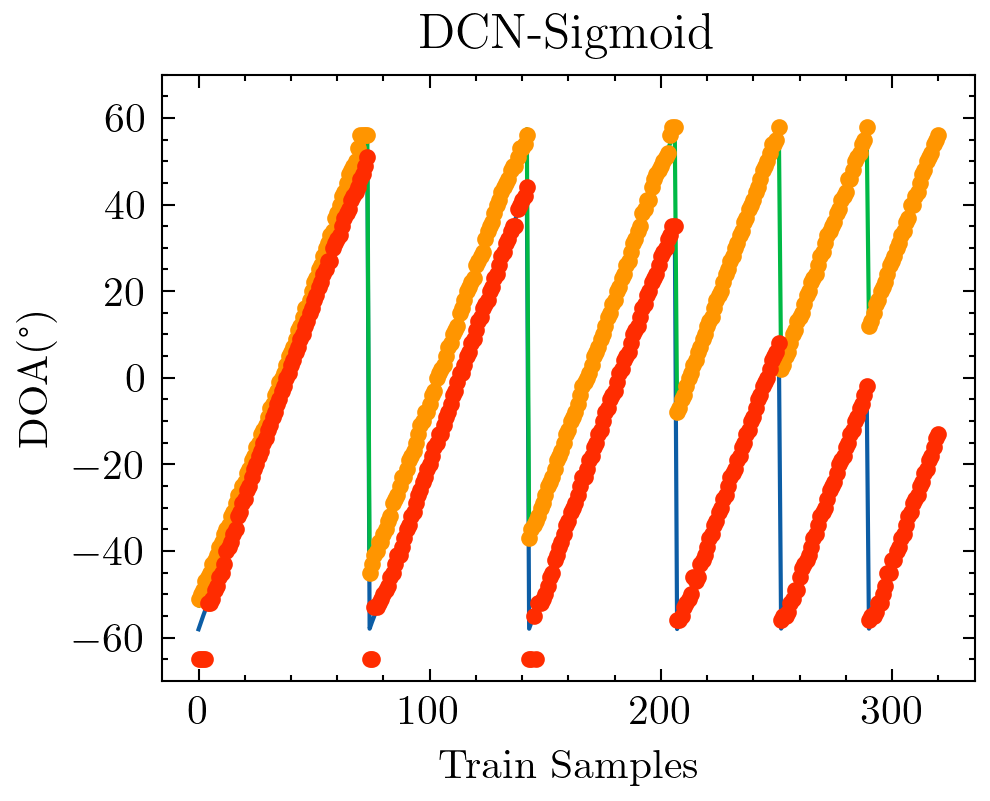

In [372]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(-70,70)
    plt.plot(DOA_train.T)
    plt.plot(doa_cnnsigmoid.T-60,'.')
    plt.title('DCN-Sigmoid')
    plt.xlabel('Train Samples')
    plt.ylabel('DOA(°)')
    plt.savefig(figurepath + 'SampleIndex/DCN_Sigmoid.pdf')
    plt.show()

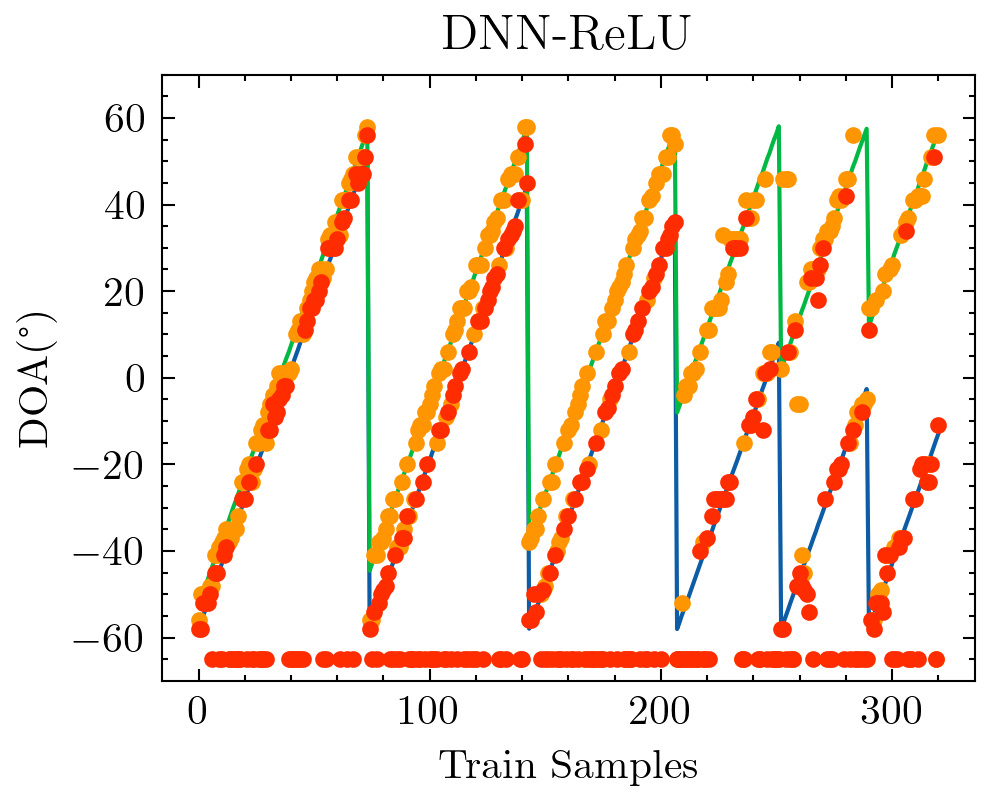

In [368]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(-70,70)
    plt.plot(DOA_train.T)
    plt.plot(doa_dnnrelu.T-60,'.')
    plt.title('DNN-ReLU')
    plt.xlabel('Train Samples')
    plt.ylabel('DOA(°)')
    plt.savefig(figurepath + 'SampleIndex/DNN_ReLU.pdf')
    plt.show()

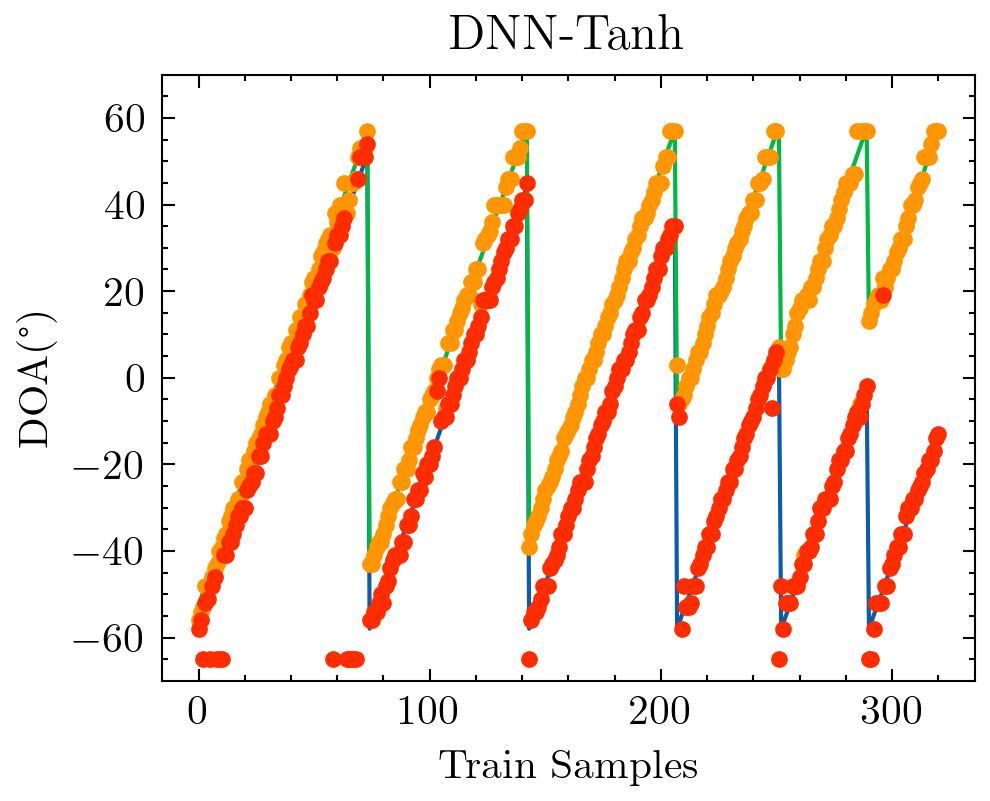

In [369]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(-70,70)
    plt.plot(DOA_train.T)
    plt.plot(doa_dnntanh.T-60,'.')
    plt.title('DNN-Tanh')
    plt.xlabel('Train Samples')
    plt.ylabel('DOA(°)')
    plt.savefig(figurepath + 'SampleIndex/DNN_Tanh.pdf')
    plt.show()

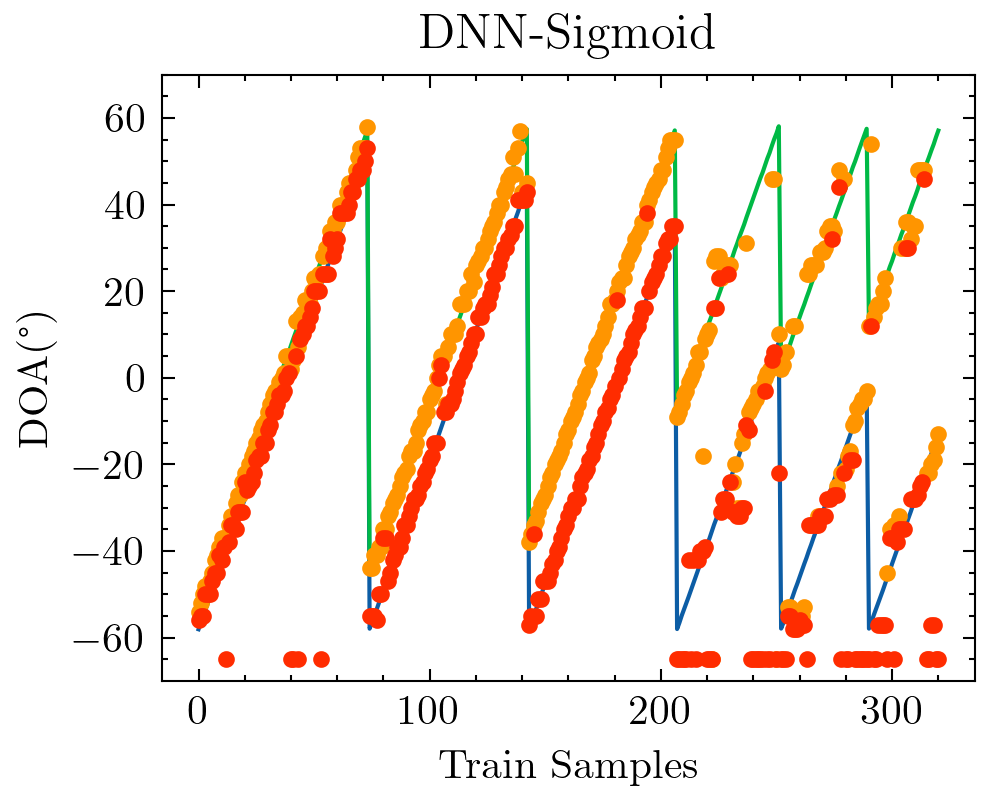

In [370]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(-70,70)
    plt.plot(DOA_train.T)
    plt.plot(doa_dnnsigmoid.T-60,'.')
    plt.title('DNN-Sigmoid')
    plt.xlabel('Train Samples')
    plt.ylabel('DOA(°)')
    plt.savefig(figurepath + 'SampleIndex/DNN_Sigmoid.pdf')
    plt.show()